# Inicializace

In [6]:
from tensorflow import keras
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import h5py

from __future__ import print_function

import tensorflow as tf
import os
import numpy as np
from sklearn.utils import class_weight
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D,Conv3DTranspose, ZeroPadding3D, Activation, Input, Dropout
from keras.layers import MaxPooling3D, UpSampling3D, concatenate
from keras.models import Model
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile
import h5py
import json
from typing import Tuple
#import skimage.transform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Conv3DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy


def uloz(filename, model):
    model.save_weights('weights__' + filename + '.h5')
    with open('history__' + filename + '.json', 'w') as f:
        json.dump(model.history.history, f)
        
        
def nacti_model(filename,rozmer,version):
    f = open(os.getcwd() +  '/history__' + filename + '.json') 
    data = json.load(f)
    f.close()
    print('Delka historie: ' + str(len(data['loss'])))
    
    class_weights = [0.5,30]
    model = get_unet(version=version, shape=(rozmer,rozmer,rozmer), class_weights=None)
    model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy"])
    model.load_weights(os.getcwd() +  '/weights__' + filename + '.h5')    
    model.fit(X_train, Y_train, epochs=1,validation_data=(X_val, Y_val),validation_freq=1)
    model.history.history = data
    return model


def get_unet(version=1, shape=(50,50,50), class_weights=None):
    K.set_image_data_format('channels_last')
    inputs = Input((shape[0], shape[1], shape[2], 1))
    
    if(version == 1):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)
        #bottleneck
        conv3 = Conv3D(512, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv3D(512, 3, activation='relu', padding='same')(conv3)
        drop3 = Dropout(0.5)(conv3)

        up4 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv4 = Conv3D(64, 3, activation='relu', padding='same')(up4)
        conv4 = Conv3D(64, 3, activation='relu', padding='same')(conv4)

        up5 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv5 = Conv3D(32, 3, activation='relu', padding='same')(up5)
        conv5 = Conv3D(32, 3, activation='relu', padding='same')(conv5)

        conv6 = Conv3D(1, 1, activation='sigmoid')(conv5)
        model = Model(inputs=[inputs], outputs=[conv6])
    
    if(version == 2):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)
        #bottleneck
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        up6 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv6 = Conv3D(256, 3, activation = 'relu', padding = 'same')(up6)
        conv6 = Conv3D(256, 3, activation = 'relu', padding = 'same')(conv6)

        up7 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv7 = Conv3D(128, 3, activation='relu', padding='same')(up7)
        conv7 = Conv3D(128, 3, activation='relu', padding='same')(conv7)

        up8 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv8 = Conv3D(64, 3, activation='relu', padding='same')(up8)
        conv8 = Conv3D(64, 3, activation='relu', padding='same')(conv8)

        up9 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv9 = Conv3D(32, 3, activation='relu', padding='same')(up9)
        conv9 = Conv3D(32, 3, activation='relu', padding='same')(conv9)

        conv10 = Conv3D(1, 1, activation='sigmoid')(conv9)
        model = Model(inputs=[inputs], outputs=[conv10])
        
    if(version == 3):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)
    
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
        pool5 = MaxPooling3D(pool_size=(2, 2, 2))(conv5)
        drop5 = Dropout(0.5)(conv5)
    
        conv6 = Conv3D(1024, 3, activation='relu', padding='same')(pool5)
        conv6 = Conv3D(1024, 3, activation='relu', padding='same')(conv6)
        pool6 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)
        drop6 = Dropout(0.5)(conv6)
        #bottleneck
        conv7 = Conv3D(1024, 3, activation='relu', padding='same')(pool6)
        conv7 = Conv3D(1024, 3, activation='relu', padding='same')(conv7)
        drop7 = Dropout(0.5)(conv7)
        
        up8 = Conv3D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop7))
        conv8 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
        conv8 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop6))
        conv9 = Conv3D(512, 3, activation='relu', padding='same')(up9)
        conv9 = Conv3D(512, 3, activation='relu', padding='same')(conv9)
    
        up10 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(up10)
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(conv10)
    
        up11 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(up11)
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(conv11)

        up12 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(up12)
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(conv12)

        up13 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(up13)
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(conv13)

        conv14 = Conv3D(1, 1, activation='sigmoid')(conv13)
        model = Model(inputs=[inputs], outputs=[conv14])       
        
    return model

def trenuj(model, epoch):
    history = model.history
    h = model.fit(
        train_generator,
        epochs= epoch,
        steps_per_epoch=X_train.shape[0] // batch_size,
        validation_data=val_generator,
        validation_steps=X_val.shape[0] // batch_size,
        validation_freq=1
    )

    for i in range(len(h.history['loss'])):
        history.history['loss'].append(h.history['loss'][i])        
        history.history['val_loss'].append(h.history['val_loss'][i])
        history.history['dice_coef'].append(h.history['dice_coef'][i])
        history.history['val_dice_coef'].append(h.history['val_dice_coef'][i])
        history.history['accuracy'].append(h.history['accuracy'][i])
        history.history['val_accuracy'].append(h.history['val_accuracy'][i])
        
    model.history = history

In [8]:
def nacti(file, index):
    f = h5py.File(file, 'r')
    raw = f["raw"][index,:,:,:,0]
    seg = f["seg"][index,:,:,:,0]
    bif = f["bif"][index,:,:,:,0]
    centerline = f["centerline"][index,:,:,:,0]
    f.close
    return raw,seg,bif,centerline

def vykresli_data(data):    
    # plot with various axes scales
    plt.figure()

    # raw
    plt.subplot(4,4,1)
    plt.imshow(data[0][:,:,220])
    plt.title('raw')
    plt.grid(False)

    # seg
    plt.subplot(4,4,2)
    plt.imshow(data[1][:,:,220])
    plt.title('seg')
    plt.grid(False)

    # bif
    plt.subplot(4,4,3)
    plt.imshow(data[2][:,:,220])
    plt.title('bif')
    plt.grid(False)

    # centerline
    plt.subplot(4,4,4)
    plt.imshow(data[3][:,:,220])
    plt.title('centerline')
    plt.grid(False)
    
    # Adjust the subplot layout, because the logit one may take more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    plt.gcf().set_size_inches(20, 20)
    plt.subplots_adjust(top=0.7, bottom=0.1, left=0.10, right=0.95, hspace=0.1, wspace=0.35)
    plt.show()
    

def data(dir_root,rozmer,index,pocet,adresar_index):
    d = nacti(dir_root,index)
    shape = d[0].shape
    delka = int(shape[0]/rozmer)
    sirka = int(shape[1]/rozmer)
    hloubka = int(shape[2]/rozmer)

    X = []
    Y = []

    for p in range(pocet):
        d = nacti(dir_root,index + p)
        predlohaX = np.zeros((rozmer, rozmer, rozmer, 1))
        predlohaY = np.zeros((rozmer, rozmer, rozmer, 1))
        for o in range(delka):
            for j in range(sirka):
                for k in range(hloubka):
                    predlohaX[:,:,:,0] = d[0][(o%delka)*rozmer:(o%delka+1)*rozmer,(j%sirka)*rozmer:(j%sirka+1)*rozmer,(k%hloubka)*rozmer:(k%hloubka+1)*rozmer] #raw 
                    predlohaY[:,:,:,0] = d[adresar_index][(o%delka)*rozmer:(o%delka+1)*rozmer,(j%sirka)*rozmer:(j%sirka+1)*rozmer,(k%hloubka)*rozmer:(k%hloubka+1)*rozmer] #seg
                    X.append(predlohaX) #raw                    
                    Y.append(predlohaY) #seg

    Y = np.array(Y).astype('float64')
    X = np.array(X).astype('int16')    
    return X,Y

def img_generator(img_dir, mask_dir, batch_size):
    while True:
        ix = np.random.choice(np.arange(img_dir.shape[0]), batch_size)
        imgs = []
        labels = []

        for i in ix:
            imgs.append(img_dir[i])
            labels.append(mask_dir[i])

        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels
    
def vykresli(model):
    plt.figure()
    plt.subplot(4,4,1)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['dice_coef'])
    plt.plot(model.history.history['accuracy'])
    plt.title('Průběh trénování')
    plt.ylabel('Metrika')
    plt.xlabel('Epochy')
    plt.legend(['Loss', 'Dice_coeficient', 'Accuracy'], loc='lower right')
    plt.grid(False)
    
    plt.subplot(4,4,2)
    plt.plot(model.history.history['val_loss']) 
    plt.plot(model.history.history['val_dice_coef'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Průběh trénování')
    plt.ylabel('Metrika')
    plt.xlabel('Epochy')
    plt.legend(['val_Loss', 'val_Dice_coeficient', 'val_Accuracy'], loc='lower right')
    plt.grid(False)
    
    # Adjust the subplot layout, because the logit one may take more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    plt.gcf().set_size_inches(20, 20)
    plt.subplots_adjust(top=0.7, bottom=0.1, left=0.10, right=0.95, hspace=0.1, wspace=0.35)
    plt.show()

# Data

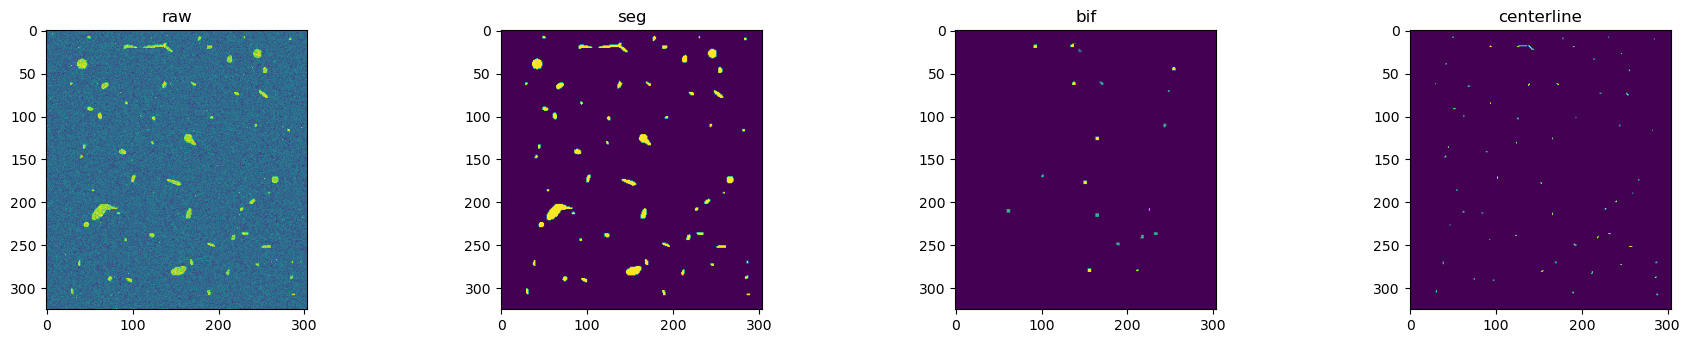


Train:
(432, 50, 50, 50, 1) int16 1 255
(432, 50, 50, 50, 1) float64 0.0 1.0

Validation:
(432, 50, 50, 50, 1) int16 3 255
(432, 50, 50, 50, 1) float64 0.0 1.0

Test:
(432, 50, 50, 50, 1) int16 12 255
(432, 50, 50, 50, 1) float64 0.0 1.0


In [9]:
dir_root_train =  os.getcwd() + '/dataset_train_small.h5'
dir_root_val =  os.getcwd() + '/dataset_validation_small.h5'
dir_root_test =  os.getcwd() + '/dataset_test_small.h5'

rozmer = 50
adresare = ["raw","seg","bif","centerline"]
adresar_index = 1  

pocet_train_souboru = 1
pocet_val_souboru = 1
pocet_test_souboru = 1
###############################################

vykresli_data(nacti(dir_root_train, 1))

X_train, Y_train = data(dir_root_train,rozmer, 0, pocet_train_souboru, adresar_index)
X_val, Y_val = data(dir_root_val,rozmer, 0, pocet_val_souboru, adresar_index)
X_test, Y_test = data(dir_root_test,rozmer, 0, pocet_test_souboru, adresar_index) 

print('\nTrain:')
print(X_train.shape, X_train.dtype, np.min(X_train), np.max(X_train))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_train.shape, Y_train.dtype, np.min(Y_train), np.max(Y_train)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print('\nValidation:')
print(X_val.shape, X_val.dtype, np.min(X_val), np.max(X_val))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_val.shape, Y_val.dtype, np.min(Y_val), np.max(Y_val)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print('\nTest:')
print(X_test.shape, X_test.dtype, np.min(X_test), np.max(X_test))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_test.shape, Y_test.dtype, np.min(Y_test), np.max(Y_test)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)


Train generator ukazka [x, y]: 
(10, 50, 50, 50, 1) int16 1 255
(10, 50, 50, 50, 1) float64 0.0 1.0


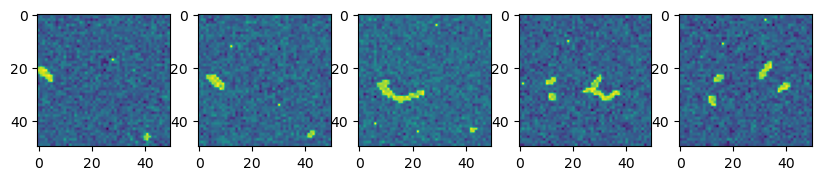

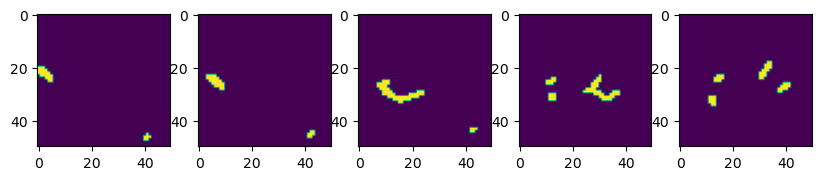

In [10]:
batch_size = 10
velikost_train = 10
velikost_val = 10
velikost_test = 10
#######################################################
X_train = X_train[0:velikost_train]
Y_train = Y_train[0:velikost_train]
X_val = X_val[0:velikost_val]
Y_val = Y_val[0:velikost_val]
X_test = X_test[0:velikost_test]
Y_test = Y_test[0:velikost_test]

train_generator = img_generator(X_train, Y_train , batch_size)
val_generator = img_generator(X_val, Y_val, batch_size)
test_generator = img_generator(X_test, Y_test, batch_size)
##################################################################
x, y = next(train_generator)

print('DATASET: ')
print (X_train.shape, X_train.dtype, np.min(x), np.max(x))
print('\nTrain generator ukazka [x, y]: ')
print(x.shape, x.dtype, np.min(x), np.max(x))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(y.shape, y.dtype, np.min(y), np.max(y)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[0,:,:,2*i,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(y[0,:,:,2*i,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

# Vytvoř nový model

In [14]:
version_of_unet = 1   #1 , 2, 3
#####################################################################################
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train.flatten()), y=Y_train.flatten()) #class_weights = [0.5, 30]
print('class_weights: ' + str(class_weights))
print('X_train:' + str(X_train.shape[0]), 'batch_size:' + str(batch_size), 'steps_per_epoch:' + str(X_train.shape[0] // batch_size))
print('X_valid:' + str(X_train.shape[0]), 'batch_size:' + str(batch_size), 'steps_per_epoch:' + str(X_train.shape[0] // batch_size))
print()

model = get_unet(version=1, shape=(rozmer,rozmer,rozmer))
model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy"])
model.fit(X_train, Y_train, epochs=1,validation_data=(X_val, Y_val),validation_freq=1)

class_weights: [ 0.50889964 28.59103385]
X_train:10 batch_size:10 steps_per_epoch:1
X_valid:10 batch_size:10 steps_per_epoch:1

1/1 [==============================] - 15s 15s/step - loss: 3.7116 - dice_coef: 0.0346 - accuracy: 0.0272 - val_loss: 1.7338 - val_dice_coef: 0.0062 - val_accuracy: 0.9890


# Trenování

In [ ]:
epochy = 50
kolikrat = 4
#####################################
for i in range(kolikrat):
    print('\nTrenován:' + str(i+1))
    filename = str(adresare[adresar_index]) + str(version_of_unet) + '_' + str(X_train.shape[0]) + 'dat_' + str(epochy*(i+1)) + 'epoch'    
    
    trenuj(model, epochy)
    uloz(filename, model)

In [ ]:
vykresli(model)

# Načti uložený model

In [ ]:
version_of_unet = 1   #1 , 2, 3
load_file = 'seg1_10dat_50epoch'
###########################
model = nacti_model(load_file,rozmer=rozmer,version=version_of_unet)
vykresli(model)

# Vyhodnoceni

In [ ]:
result = model.evaluate(X_test,Y_test)
a = model.predict(X_test)

In [ ]:
print('Výsledek testování: ')
print('\tLoss: ' + str(result[0]))
print('\tDice_coef: ' + str(result[1]))
print('\tAccuracy: ' + str(result[2]) + '\n')
print('Tvar predikce: ' + str(a.shape))

soubor = 0
vrstva = 40

plt.subplot(5, 5, 1)
plt.imshow(X_test[soubor,:,:,vrstva])
plt.subplot(5, 5, 2)
plt.imshow(Y_test[soubor,:,:,vrstva])
plt.subplot(5, 5, 3)
plt.imshow(a[soubor,:,:,vrstva,0])
plt.gcf().set_size_inches(10, 10)
plt.show()